## Packages

### Libraries

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import time
import requests
from datetime import datetime
from dateutil.relativedelta import relativedelta


# For creating cool charts :)
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.ticker as mtick
from matplotlib import image
import matplotlib as mpl
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.dates as mdates

# We load pre-defined functions, fonts and stylesheet.
module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path+"\\utils")
    sys.path.append(module_path+"\\assets")

from tukan_helper_functions import *

path = [x for x in sys.path if "utils" in x][0]

# Optional for TUKAN's mplstylesheet
plt.style.use(module_path + '\\utils\\tukan_style.mpl')

### Customized functions

In [2]:
# Filter dataframe by date range or for two specific dates
def date_selection(data_frame,first_date,last_date,inbewtween):
    if inbewtween==True:
        data_frame = data_frame[(data_frame["date"] >= first_date) & (data_frame["date"] <= last_date)].reset_index(drop = True)
    else:
        data_frame = data_frame[(data_frame["date"] == first_date) | (data_frame["date"] == last_date)].reset_index(drop = True)
    return(data_frame)

# Return last date for any dataframe with a 'date' columns
def last_date(dataframe):
    x= dataframe['date'].tail(1).dt.strftime('%Y-%m-%d').to_string()[-10:]
    return(x)

## Data

### Payload

In [3]:
# Main payload
payload ={
    "type": "data_table",
    "operation": "yoy_growth_rel",
    "language": "es",
    "group_by": [
        "economic_activity"
    ],
    "categories": {
        "economic_activity": [
            "dfeefc621d16d0c"
        ]
    },
    "request": [
        {
            "table": "mex_inegi_inpc_scian_monthly",
            "variables": [
                "c572db59b8cd109"
            ]
        }
    ],
    "from": "2000-01-01"
}

response = get_tukan_api_request(payload)

inflation = response["data"]
inflation.values

Success getting the data


array([[Timestamp('2000-01-01 00:00:00'), 'dfeefc621d16d0c',
        'Actividad económica', 0.11023190890385592],
       [Timestamp('2000-02-01 00:00:00'), 'dfeefc621d16d0c',
        'Actividad económica', 0.10522686316843388],
       [Timestamp('2000-03-01 00:00:00'), 'dfeefc621d16d0c',
        'Actividad económica', 0.10112402355819405],
       ...,
       [Timestamp('2021-10-01 00:00:00'), 'dfeefc621d16d0c',
        'Actividad económica', 0.06239542537738796],
       [Timestamp('2021-11-01 00:00:00'), 'dfeefc621d16d0c',
        'Actividad económica', 0.07374880576174037],
       [Timestamp('2021-12-01 00:00:00'), 'dfeefc621d16d0c',
        'Actividad económica', 0.07355107942638028]], dtype=object)

In [4]:
payload = {
    "type": "data_table",
    "operation": "sum",
    "language": "es",
    "group_by": [
        ""
    ],
    "categories": {},
    "request": [
        {
            "table": "mex_banxico_cf102",
            "variables": [
                "b81e60ba1288ef6"
            ]
        }
    ],
    "from": "2000-01-01"
}

response = get_tukan_api_request(payload)
exc_rate = response["data"]
exc_rate

Success getting the data


,date,b81e60ba1288ef6
0,2000-01-03,9.3949
1,2000-01-04,9.4564
2,2000-01-05,9.5455
3,2000-01-06,9.5705
4,2000-01-07,9.5150
...,...,...
5556,2022-01-26,20.6415
5557,2022-01-27,20.7383
5558,2022-01-28,20.8597
5559,2022-01-31,20.6352


### Transformations

In [5]:
final_data=exc_rate.copy()
final_data['change'] = (final_data['b81e60ba1288ef6']/final_data['b81e60ba1288ef6'].shift())-1
final_data['year_month'] = final_data['date'].dt.strftime('%Y-%m')

temp = final_data.groupby('year_month').count()
temp.drop(['date','b81e60ba1288ef6'], axis=1,inplace=True)
temp.rename(columns={'change':'count'}, inplace=True)
final_data = pd.merge(final_data, temp, how='left', on='year_month')

temp = final_data[['change','year_month']].groupby('year_month').std()
temp.rename(columns={'change':'month_std'}, inplace=True)
final_data = pd.merge(final_data, temp, how='left', on='year_month')

final_data['var'] = (final_data['month_std']*final_data['count'])**(1/2)
final_data = final_data[['year_month','var']].drop_duplicates()
final_data.reset_index(drop=True, inplace=True)
final_data['year_month'] = final_data['year_month'].astype(str) + '-01'
final_data["year_month"] = pd.to_datetime(final_data["year_month"])
final_data.drop(final_data.tail(1).index,inplace=True)
final_data['var'] = final_data['var'].astype(float)
final_data

,year_month,var
0,2000-01-01,0.311436
1,2000-02-01,0.258707
2,2000-03-01,0.274773
3,2000-04-01,0.308938
4,2000-05-01,0.321814
...,...,...
260,2021-09-01,0.303444
261,2021-10-01,0.313221
262,2021-11-01,0.417000
263,2021-12-01,0.370143


In [6]:
final_data.values

array([[Timestamp('2000-01-01 00:00:00'), 0.3114356663871224],
       [Timestamp('2000-02-01 00:00:00'), 0.2587069415400698],
       [Timestamp('2000-03-01 00:00:00'), 0.2747729153148431],
       [Timestamp('2000-04-01 00:00:00'), 0.3089382289560934],
       [Timestamp('2000-05-01 00:00:00'), 0.32181368255588355],
       [Timestamp('2000-06-01 00:00:00'), 0.3978699710470282],
       [Timestamp('2000-07-01 00:00:00'), 0.39024645972918937],
       [Timestamp('2000-08-01 00:00:00'), 0.26600194679848044],
       [Timestamp('2000-09-01 00:00:00'), 0.26262763734097216],
       [Timestamp('2000-10-01 00:00:00'), 0.28208404382499447],
       [Timestamp('2000-11-01 00:00:00'), 0.27251898957890675],
       [Timestamp('2000-12-01 00:00:00'), 0.30033666748380944],
       [Timestamp('2001-01-01 00:00:00'), 0.38080366466654675],
       [Timestamp('2001-02-01 00:00:00'), 0.2694412015037748],
       [Timestamp('2001-03-01 00:00:00'), 0.3100978524496588],
       [Timestamp('2001-04-01 00:00:00'), 0.323

## Plots

### Heatmap

In [7]:
month_ticks = final_data['year_month'].dt.month.tolist()
year_ticks = final_data['year_month'].dt.year.tolist()

TypeError: Image data of dtype object cannot be converted to float

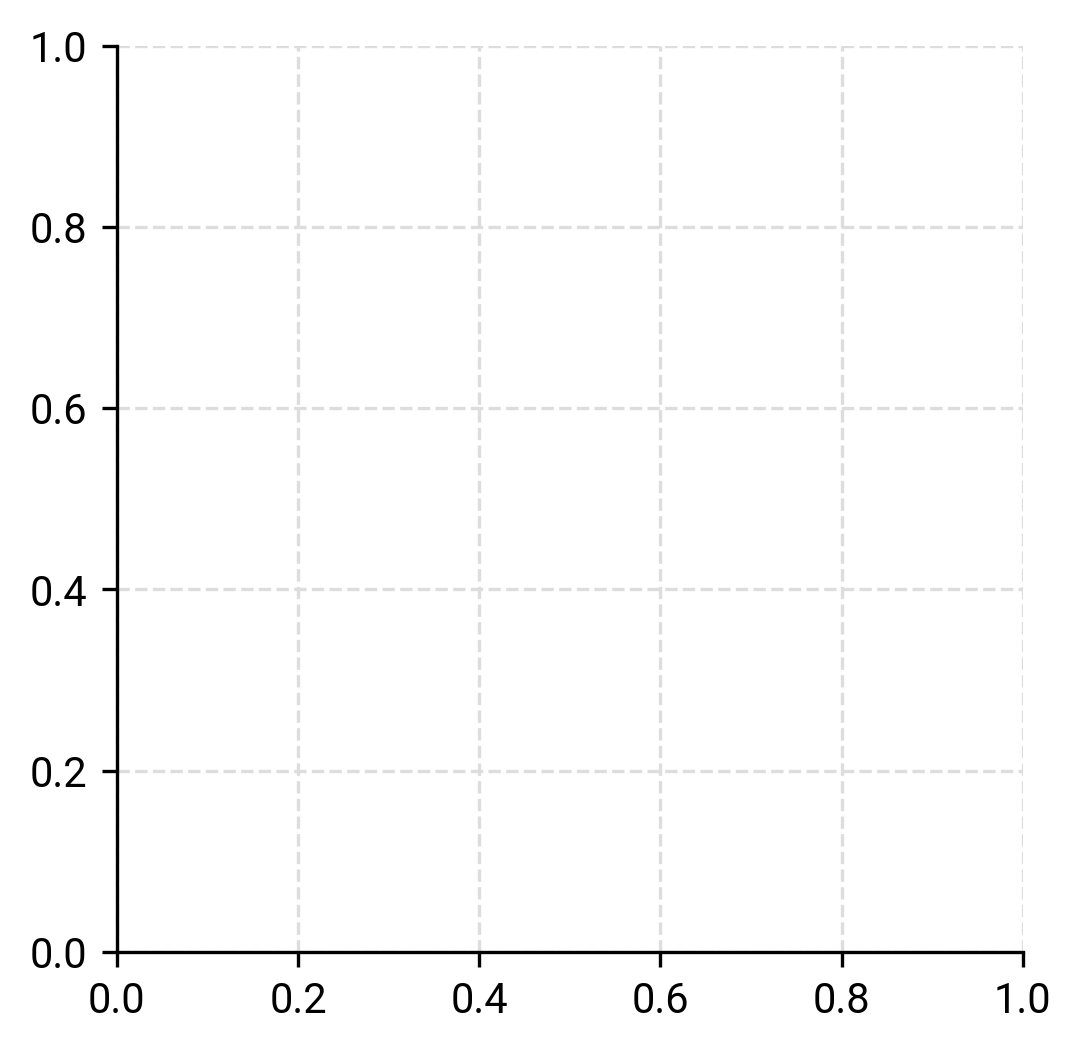

In [8]:
fig = plt.figure(dpi=300, figsize=(8,4))
ax = plt.subplot(111)

# Data to plot
heatmap = ax.imshow(final_data.values, zorder=2, cmap = "Blues")

# Add gridlines and format to ticks 
ax.set_yticks(np.arange(len(month_ticks)), labels=month_ticks)
ax.set_xticks(np.arange(len(year_ticks)), labels=year_ticks, rotation=90)
# ax.grid(which="major", color="w", linestyle='-', linewidth=3)
fig.colorbar(heatmap, fraction=0.05, pad=0.04, format = ticker.StrMethodFormatter('{x:,.0%}'))

# Add title and subtitle
fig.text(
    0.15,
    1,
    "Título",
    size=14,
    weight = "bold"
)
fig.text(
    0.15,
    0.92,
    "Subtítulo",
    size=8
)
# Add footer
fig.text(0.18, -0.05, "Fuente: TUKAN, INEGI", fontsize=8)

# Save plot with TUKAN logo, transparent and white
# plt.savefig(
#     "plots/exchange_rate_heatmap_no_logo.svg",
#     dpi=300,
#     bbox_inches="tight",
#     # facecolor="white",
#     edgecolor="none",
#     transparent=True,
# )

tukan_im = image.imread(module_path + "\\assets\\logo\\logo192.png")
newax = fig.add_axes([0.75, .88, 0.16, 0.19], anchor="NE", zorder=1)
newax.imshow(tukan_im)
newax.axis("off")

# plt.savefig(
#     "plots/exchange_rate_heatmap_logo.png",
#     dpi=300,
#     bbox_inches="tight",
#     # facecolor="white",
#     edgecolor="none",
#     transparent=True,
# )

# plt.savefig(
#     "plots/exchange_rate_heatmap_white_logo.png",
#     dpi=300,
#     bbox_inches="tight",
#     facecolor="white",
#     edgecolor="none",
#     transparent=False,
# )

### Line

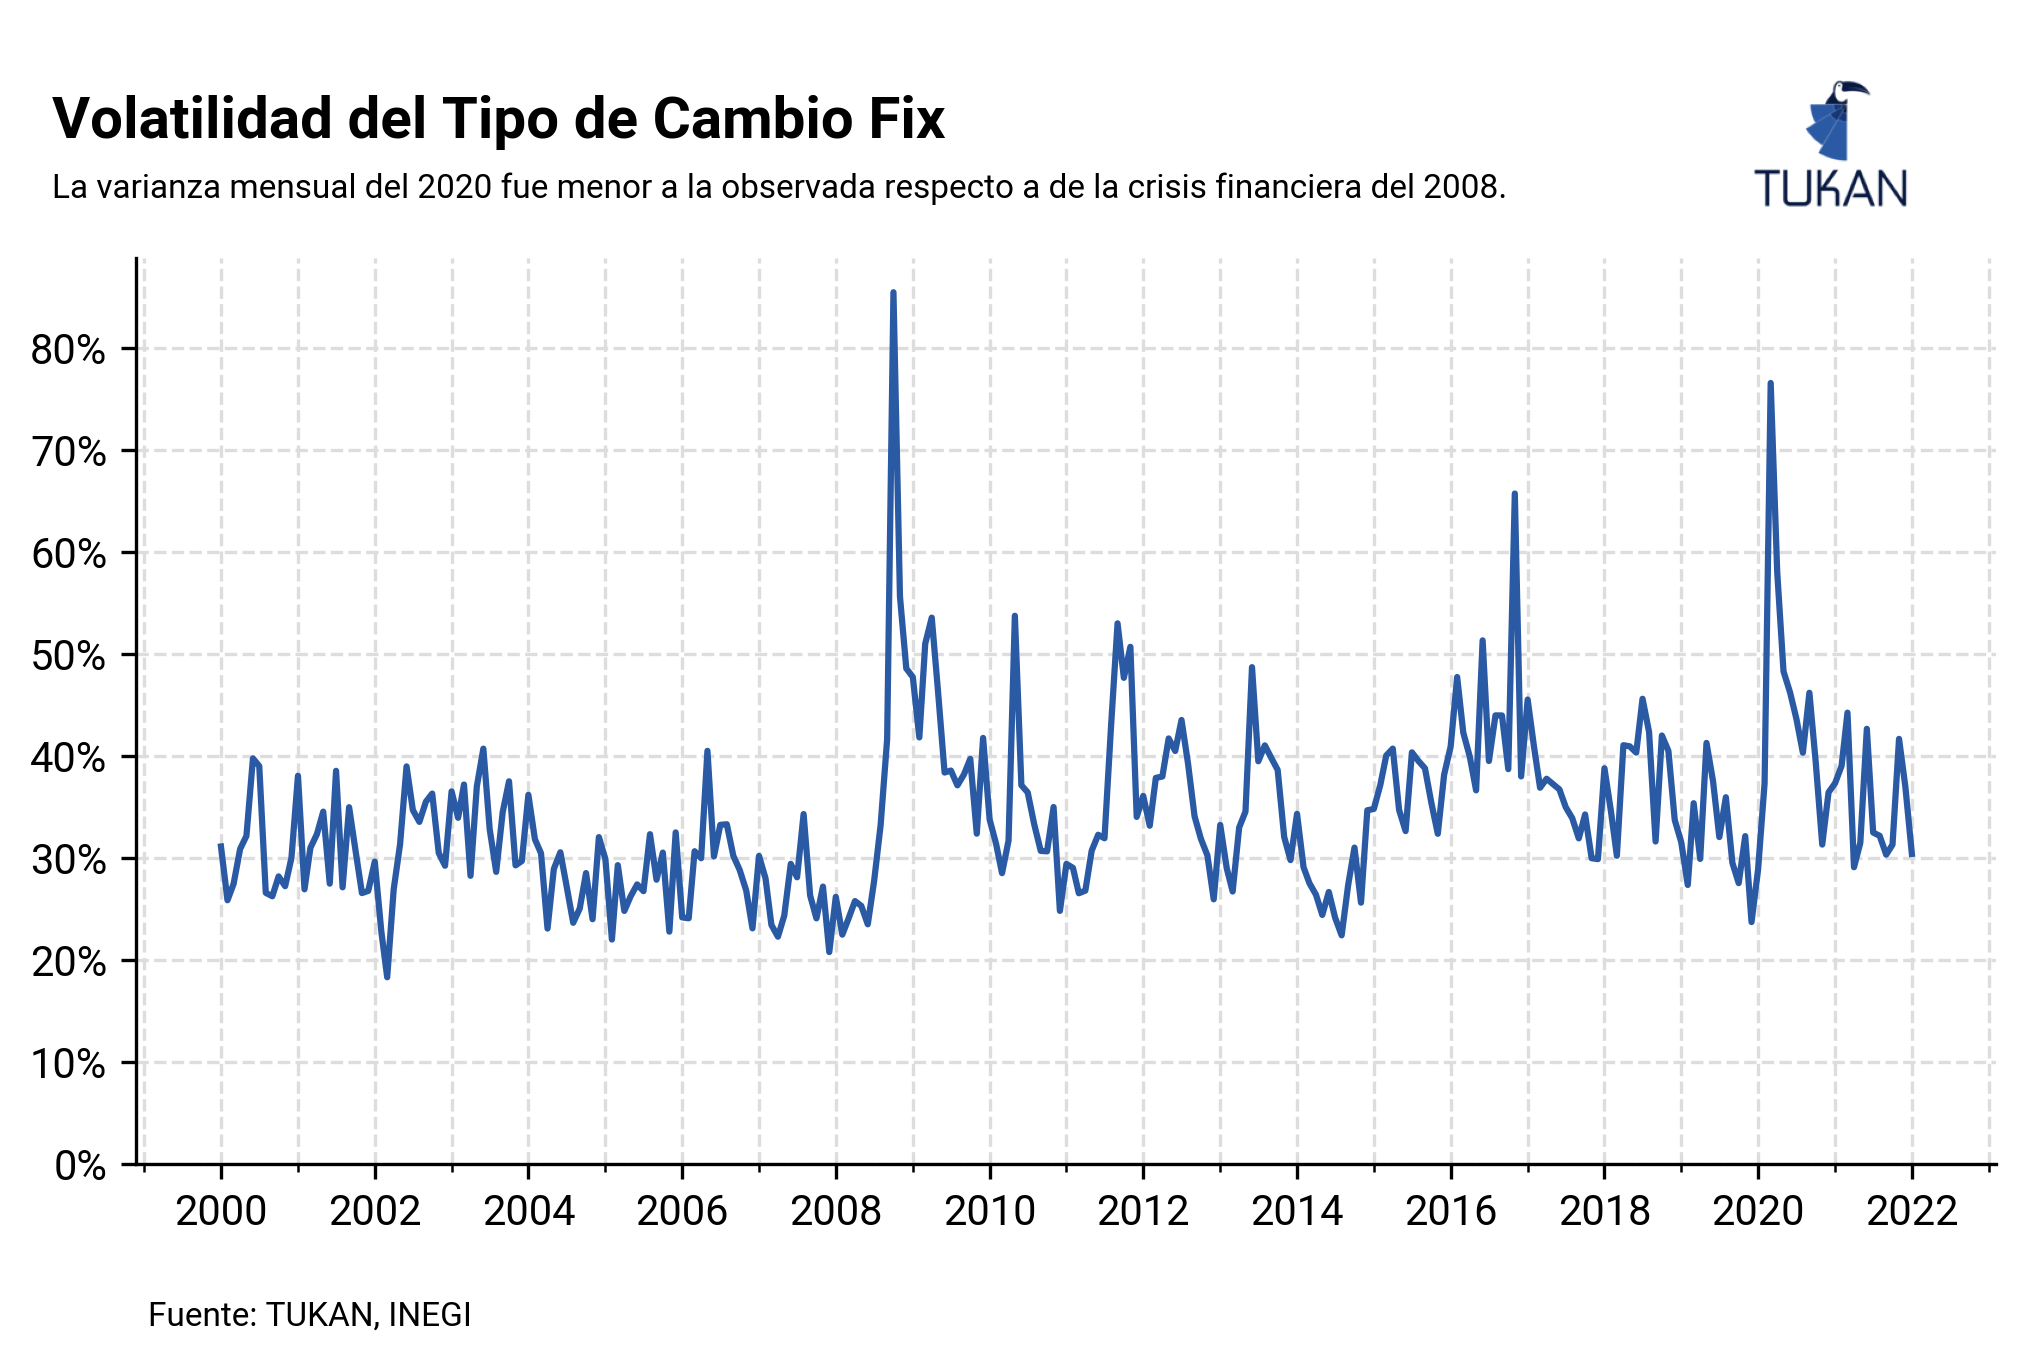

In [ ]:
fig = plt.figure(dpi=300, figsize=(8,4))
ax = plt.subplot(111)

ax.plot(final_data["year_month"], final_data["var"])

ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0%}'))
# Add minor gridlines and format ticks
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_minor_locator(mdates.YearLocator(1))

ax.grid(visible=True, which='minor', linestyle='--')

ax.set_ylim(0)

fig.text(
    0.09,
    .98,
    "Volatilidad del Tipo de Cambio Fix",
    size=14,
    weight = "bold"
)
fig.text(
    0.09,
    0.93,
    "La varianza mensual del 2020 fue menor a la observada respecto a de la crisis financiera del 2008.",
    size=8
)
# Add footer
fig.text(0.13, -0.01, "Fuente: TUKAN, INEGI", fontsize=8)

# Save plot with TUKAN logo, transparent and white
plt.savefig(
    "plots/exchange_rate_line_no_logo.svg",
    dpi=300,
    bbox_inches="tight",
    # facecolor="white",
    edgecolor="none",
    transparent=True,
)

tukan_im = image.imread(module_path + "\\assets\\logo\\logo192.png")
newax = fig.add_axes([0.72, .88, 0.16, 0.19], anchor="NE", zorder=1)
newax.imshow(tukan_im)
newax.axis("off")

plt.savefig(
    "plots/exchange_rate_line_logo.png",
    dpi=300,
    bbox_inches="tight",
    # facecolor="white",
    edgecolor="none",
    transparent=True,
)

plt.savefig(
    "plots/exchange_rate_line_white_logo.png",
    dpi=300,
    bbox_inches="tight",
    facecolor="white",
    edgecolor="none",
    transparent=False,
)